- エンゼルの予測を金と銀合わせて行う
    - 多項分布で3状態（ハズレ、銀、金）の確率をパラメータとした推論を行う

In [1]:
import os, sys
import numpy as np
import pandas as pd
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm


import ChocoUtils as cu

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set()

# データの取得
- campaign=1は「金のエンゼル2倍キャンペーン」
    - この期間は金のエンゼルの出現確率は2倍になるが、銀のエンゼルの出現は0になる
- acgelカラム
    - angelの有無を示す
    - 0:なし
    - 1:銀のエンゼル
    - 2:金のエンゼル

In [3]:
dbfile = '../../data/choco-ball.db'
data = cu.get_data(db_file=dbfile, filter_str="taste is not 10")
data = data.drop(columns=['shop', 'factory'])
data.head()

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE taste is not 10;
Shape of MeasurementData(record_num, n_columns) : (566, 14)


,measure_date,best_before,prd_number,weight,box_weight,ball_number,angel,campaign,taste,buyer,net_weight,mean_weight
0,2017-11-19,None,None,34.002,4.756,16,0,1,0,時田,29.246,1.827875
1,2017-11-20,None,None,34.435,4.805,17,0,1,0,時田,29.630,1.742941
2,2017-11-21,2018-06-01,None,34.000,4.815,18,0,1,0,時田,29.185,1.621389
3,2017-11-22,2018-06-01,None,34.193,4.818,17,0,1,0,時田,29.375,1.727941
4,2017-11-23,2018-06-01,None,35.344,4.836,16,0,1,0,時田,30.508,1.906750


# エンゼル出現確率の推定

## データの前処理
- モデルが想定する形にデータを加工
    - 今回、キャンペーンIDが1か否かで出現確率が公式に変わることが公表されているため、データを2つの期間に分ける
    - エンゼルの[なし、銀、金]の個数をデータにする（多項分布を仮定する）

In [4]:
data_1 = data.query('campaign == 1')
data_0 = data.query('campaign != 1')

In [5]:
dict_sum = dict()
dict_sum['c1'] = {'gold':sum(data_1['angel']==2), 
                  'silver':sum(data_1['angel']==1), 
                  'none':sum(data_1['angel']==0)
                 }
dict_sum['c0'] = {'gold':sum(data_0['angel']==2), 
                  'silver':sum(data_0['angel']==1), 
                  'none':sum(data_0['angel']==0)
                 }
df_sum = pd.DataFrame(dict_sum).T
df_sum = df_sum[['none', 'silver', 'gold']]
df_sum

,none,silver,gold
c1,113,0,1
c0,432,20,0


## モデル1
- 簡単のため、金2倍キャンペーンのデータを除外してモデルを構築する

In [6]:
d = df_sum.loc['c0'].values

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [pi]
Sampling 3 chains: 100%|██████████| 31500/31500 [00:14<00:00, 2246.38draws/s]
The acceptance probability does not match the target. It is 0.8787170614952592, but should be close to 0.8. Try to increase the number of tuning steps.
/home/yoichi/workspace/choco-ball-statistics/env_choco/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0cfb5242e8>,
      dtype=object)

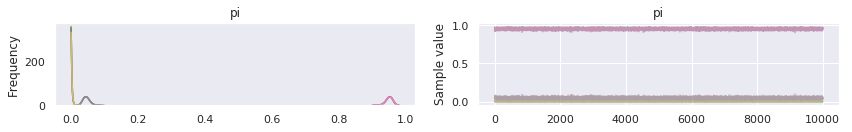

In [7]:
with pm.Model() as model1:
    # prior : Dhilichlet
    alpha = [1., 1., 1.]
    pi = pm.Dirichlet('pi', a=np.array(alpha))
    # prior : uniform　Dirichlet分布ではなく、事前知識を踏まえた分布を仮定することもできる
    #p1 = pm.Uniform('p1', 0, 0.3)
    #p2 = pm.Uniform('p2', 0, 0.1)
    #p0 = pm.Deterministic('p0', 1.0-p1-p2)
    #pi = [p0, p1, p2]
    
    # Likelihood
    m = pm.Multinomial('m', n=np.sum(d), p=pi, observed=d)
    trace1 = pm.sample(10000, chains=3)
pm.traceplot(trace1)

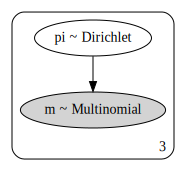

In [8]:
ret = pm.model_to_graphviz(model1)
ret.render(filename='model_01', format='png')
ret

推定結果（事後分布）を確認する。

HPDと期待値が合わせて表示されている。

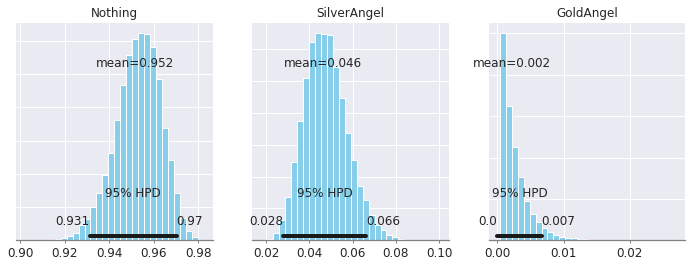

In [9]:
fig = plt.figure(figsize=(12, 4))
ax = fig.subplots(1, 3)

pm.plot_posterior(trace1['pi'][:,0], ax=ax[0])
pm.plot_posterior(trace1['pi'][:,1], ax=ax[1])
pm.plot_posterior(trace1['pi'][:,2], ax=ax[2])
ax[0].set_title('Nothing')
ax[1].set_title('SilverAngel')
ax[2].set_title('GoldAngel')
fig.savefig('angel_rate_pred_model1.png')

## モデル2
- 金の2倍キャンペーン期間のデータを加える
    - キャンペーンによって確率が変わるため、weight変数を導入する
    - http://bayesmax.sblo.jp/article/185235799.html　こちらの記事を参考にさせていただきました

In [10]:
d = df_sum.values
weight = np.array([[1.0, 0.0, 2.0], 
                   [1.0, 1.0, 1.0]])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [pi]
Sampling 3 chains: 100%|██████████| 31500/31500 [00:10<00:00, 3066.93draws/s]
/home/yoichi/workspace/choco-ball-statistics/env_choco/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0cfa4b6048>,
      dtype=object)

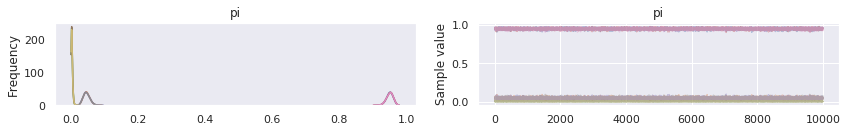

In [11]:
with pm.Model() as model2:
    alpha = [1., 1., 1.]
    pi = pm.Dirichlet('pi', a=np.array(alpha))
    for i in np.arange(d.shape[0]):
        piw = pi*weight[i]
        m = pm.Multinomial('m_%s'%(i), n=np.sum(d[i]), p=piw, observed=d[i])
    trace2 = pm.sample(10000, chains=3)
pm.traceplot(trace2)

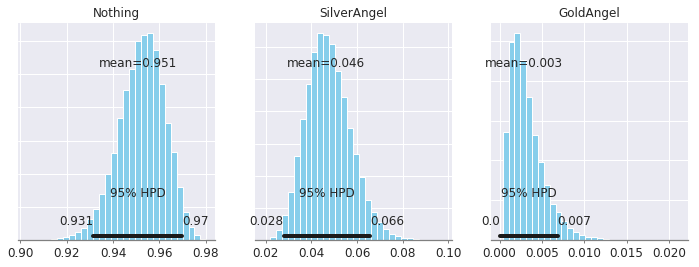

In [12]:
fig = plt.figure(figsize=(12, 4))
ax = fig.subplots(1, 3)

pm.plot_posterior(trace2['pi'][:,0], ax=ax[0])
pm.plot_posterior(trace2['pi'][:,1], ax=ax[1])
pm.plot_posterior(trace2['pi'][:,2], ax=ax[2])
ax[0].set_title('Nothing')
ax[1].set_title('SilverAngel')
ax[2].set_title('GoldAngel')
fig.savefig('angel_rate_pred_model2.png')

# いくら買えば金or銀のエンゼルが当たるか

## 銀のエンゼルが5つ当たるまでに購入が必要な個数
- 負の二項分布を利用して推定する
    - 銀のエンゼルの出現確率は上記のように事後分布で与えられているため、期待値を計算する必要がある
    - 事後分布からのサンプルを持っているため、サンプルの平均で期待値を算出できる

In [13]:
n=5
ks = np.arange(0,300,1)
p_trace = trace2['pi'][:,1]
pmf_arr = np.array(list(map(lambda p:stats.nbinom.pmf(ks, n, p), p_trace)))
pmf_expect = pmf_arr.mean(axis=0)
cdf_expect = (pmf_arr.cumsum(axis=1)).mean(axis=0)

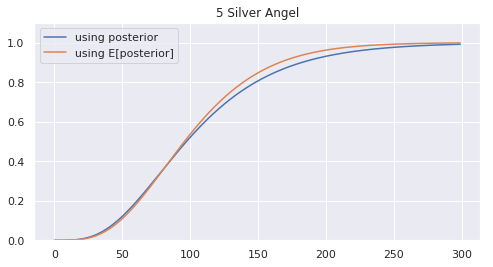

In [14]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots(1, 1)

ax.plot(cdf_expect, label='using posterior')
ax.plot(stats.nbinom.cdf(ks, n, p_trace.mean()), label='using E[posterior]')
ax.legend()
ax.set_ylim([0, 1.1])
ax.set_title('{} Silver Angel'.format(n))
fig.savefig('buy_number_silver.png')

2つのグラフはほとんど同じ。  
しかし、事後分布は若干右に裾が広いため、事後分布の期待値を使って推定した結果はほんの少しポジティブな予想になっている（見積もりが甘い）。

## 金のエンゼルが当たるまでに購入が必要な個数
- 銀のエンゼルと同様に負の二項分布を使う
    - 金のエンゼルは1つで良いので、幾何分布を利用しても良い

In [15]:
n=1
ks = np.arange(0,2000,1)
p_trace = trace2['pi'][:,2]
pmf_arr = np.array(list(map(lambda p:stats.nbinom.pmf(ks, n, p), p_trace)))
pmf_expect = pmf_arr.mean(axis=0)
cdf_expect = (pmf_arr.cumsum(axis=1)).mean(axis=0)

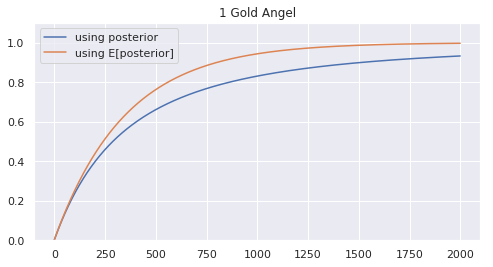

In [16]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots(1, 1)

ax.plot(cdf_expect, label='using posterior')
ax.plot(stats.nbinom.cdf(ks, n, p_trace.mean()), label='using E[posterior]')
ax.legend()
ax.set_ylim([0, 1.1])
ax.set_title('{} Gold Angel'.format(n))
fig.savefig('buy_number_gold.png')

金のエンゼルの事後分布は右に裾が広がっているため、事後分布の期待値（点推定）で購入数の見積もりを推定すると、若干ポジティブな推定となってしまう（見積もりが甘い）。